<a href="https://colab.research.google.com/github/Nabarundutta/Machine-Learning/blob/main/deIT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [2]:
import torch
from torch import nn
import os
import numpy as np
import glob
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torchvision
import pathlib
import requests
import zipfile
from pathlib import Path

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/dl/dataset.zip" -d "/content/dataset"
!ls /content/dataset/dataset/

Mounted at /content/drive
test  train  val


In [4]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

data_dir = "/content/dataset/dataset"

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # LeViT models typically use 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [6]:
train_ds = torchvision.datasets.ImageFolder(root=data_dir + "/train", transform=transform)
test_ds  = torchvision.datasets.ImageFolder(root=data_dir + "/test", transform=transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("Classes:", train_ds.classes)
print("Train samples:", len(train_ds))
print("Test samples:", len(test_ds))

Classes: ['fake', 'real']
Train samples: 2774
Test samples: 594


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models


In [8]:
%pip install timm

In [9]:
import timm

# Load pretrained DeiT model using timm
# Available DeiT variants: deit_tiny_patch16_224, deit_small_patch16_224, deit_base_patch16_224
model = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=2)

# Alternative: You can also use other DeiT variants
# model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=2)  # Fastest
# model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=2)  # Best accuracy
# model = timm.create_model('deit_small_distilled_patch16_224', pretrained=True, num_classes=2)  # With distillation

print(f"Model: {model.__class__.__name__}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

# Send to GPU/CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# DeiT typically works well with AdamW and specific hyperparameters
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)

# Optional: Add learning rate scheduler optimized for DeiT
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Model: VisionTransformer
Number of parameters: 21,666,434


In [10]:
from tqdm import tqdm

epochs = 10  # adjust

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Step the scheduler
    scheduler.step()

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_dl):.4f}, Acc: {100.*correct/total:.2f}%, LR: {current_lr:.6f}")


Epoch 1/10: 100%|██████████| 87/87 [00:26<00:00,  3.27it/s]


Epoch [1/10], Loss: 0.4769, Acc: 77.69%, LR: 0.000488


Epoch 2/10: 100%|██████████| 87/87 [00:25<00:00,  3.36it/s]


Epoch [2/10], Loss: 0.2427, Acc: 89.08%, LR: 0.000452


Epoch 3/10: 100%|██████████| 87/87 [00:26<00:00,  3.25it/s]


Epoch [3/10], Loss: 0.1628, Acc: 93.48%, LR: 0.000397


Epoch 4/10: 100%|██████████| 87/87 [00:27<00:00,  3.17it/s]


Epoch [4/10], Loss: 0.1181, Acc: 95.35%, LR: 0.000327


Epoch 5/10: 100%|██████████| 87/87 [00:28<00:00,  3.03it/s]


Epoch [5/10], Loss: 0.0738, Acc: 97.26%, LR: 0.000250


Epoch 6/10: 100%|██████████| 87/87 [00:29<00:00,  2.96it/s]


Epoch [6/10], Loss: 0.0408, Acc: 98.63%, LR: 0.000173


Epoch 7/10: 100%|██████████| 87/87 [00:28<00:00,  3.00it/s]


Epoch [7/10], Loss: 0.0321, Acc: 98.95%, LR: 0.000103


Epoch 8/10: 100%|██████████| 87/87 [00:28<00:00,  3.02it/s]


Epoch [8/10], Loss: 0.0137, Acc: 99.50%, LR: 0.000048


Epoch 9/10: 100%|██████████| 87/87 [00:29<00:00,  2.99it/s]


Epoch [9/10], Loss: 0.0043, Acc: 99.93%, LR: 0.000012


Epoch 10/10: 100%|██████████| 87/87 [00:28<00:00,  3.02it/s]

Epoch [10/10], Loss: 0.0024, Acc: 99.96%, LR: 0.000000


In [11]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100.*correct/total:.2f}%")

Test Accuracy: 94.11%


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=train_ds.classes))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

        fake       0.99      0.89      0.94       297
        real       0.90      0.99      0.94       297

    accuracy                           0.94       594
   macro avg       0.95      0.94      0.94       594
weighted avg       0.95      0.94      0.94       594

[[265  32]
 [  3 294]]


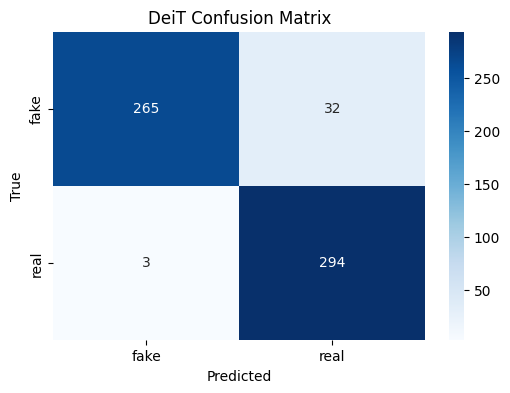

Model saved successfully!


In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DeiT Confusion Matrix")
plt.show()

# Optional: Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/dl/deit_model.pth')
print("Model saved successfully!")